In [ ]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import scipy
!pip install colorama
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix)

In [ ]:
from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import datetime

import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications import *
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard
from keras.losses import *

init_notebook_mode(connected=True)
RANDOM_SEED = 42

### **Importing the dataset**

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nikhilis007","key":"58b4620045800c66c80eceed85e45354"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d shashwatwork/knee-osteoarthritis-dataset-with-severity

100% 204M/204M [00:01<00:00, 160MB/s]
100% 204M/204M [00:01<00:00, 153MB/s]


In [ ]:
!unzip /content/knee-osteoarthritis-dataset-with-severity.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/0/9684605R.png    
  inflating: train/0/9685238L.png    
  inflating: train/0/9685238R.png    
  inflating: train/0/9686617L.png    
  inflating: train/0/9686617R.png    
  inflating: train/0/9686777R.png    
  inflating: train/0/9686834L.png    
  inflating: train/0/9686834R.png    
  inflating: train/0/9686908L.png    
  inflating: train/0/9686908R.png    
  inflating: train/0/9687273L.png    
  inflating: train/0/9689906R.png    
  inflating: train/0/9690910L.png    
  inflating: train/0/9690910R.png    
  inflating: train/0/9691359L.png    
  inflating: train/0/9691359R.png    
  inflating: train/0/9692163L.png    
  inflating: train/0/9692604L.png    
  inflating: train/0/9692604R.png    
  inflating: train/0/9692923R.png    
  inflating: train/0/9693364R.png    
  inflating: train/0/9693599L.png    
  inflating: train/0/9693599R.png    
  inflating: train/0/9694101L.png    
  inflating: train/0/9694101R.png    

In [ ]:
class_names = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

In [ ]:
train_path=r'/content/train'
test_path=r'/content/test'
valid_path=r'/content/val'

In [ ]:
for d in [train_path, test_path, valid_path]:
    filepaths = []
    labels=[]
    classlist=os.listdir(d)
    for c in classlist #5:
        n_class=int(c)
        label=class_names[n_class]
        classpath=os.path.join(d, c)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(label)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    pdf=pd.concat([Fseries, Lseries], axis=1)
    if d == test_path:
        test_df=pdf
    elif d == valid_path:
        valid_df=pdf
    else:
        train_df=pdf
print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  5778   test_df length:  1656   valid_df length:  826


In [ ]:
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)

The number of classes in the dataset is:  5


In [ ]:
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

            CLASS               IMAGE COUNT 
           Doubtful                1046     
           Healthy                 2286     
           Minimal                 1516     
           Moderate                 757     
            Severe                  173     


In [ ]:
# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)

Healthy  has the most images=  2286   Severe  has the least images=  173


In [ ]:
# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

Healthy  has the most images=  2286   Severe  has the least images=  173
average height=  224  average width=  224 aspect ratio=  1.0


In [ ]:
drop_classes = ['Minimal', 'Doubtful']

train_df = train_df[~train_df['labels'].isin(drop_classes)]
valid_df = valid_df[~valid_df['labels'].isin(drop_classes)]
test_df = test_df[~test_df['labels'].isin(drop_classes)]

# Update the list of classes
class_names = [c for c in class_names if c not in drop_classes]

# Re-calculate the total classes
class_count = len(class_names)

# Re-count the images per class
groups = train_df.groupby('labels')
for label in class_names:
    group = groups.get_group(label)
    print(label, len(group))

Healthy 2286
Moderate 757
Severe 173


In [ ]:
def get_classes(data_path, classes, data):
    print(f"---- {data} ----")
    knee_severity = {}
    count = 0

    for i in range(len(classes)):
        imgs = os.listdir(os.path.join(data_path, str(i)))
        knee_severity[i] = imgs
        count += len(imgs)

    for k, v in knee_severity.items():
        print(
            f"Grade {k} - {classes[k]}: {len(v)} images, {round((len(v) * 100) / count, 2)}%"
        )

    return knee_severity

In [ ]:
train_data = get_classes(train_path, class_names, 'Train')
valid_data = get_classes(valid_path, class_names, 'Valid')
tests_data = get_classes(test_path, class_names, 'Test')

---- Train ----
Grade 0 - Healthy: 2286 images, 47.15%
Grade 1 - Moderate: 1046 images, 21.58%
Grade 2 - Severe: 1516 images, 31.27%
---- Valid ----
Grade 0 - Healthy: 328 images, 47.33%
Grade 1 - Moderate: 153 images, 22.08%
Grade 2 - Severe: 212 images, 30.59%
---- Test ----
Grade 0 - Healthy: 639 images, 46.24%
Grade 1 - Moderate: 296 images, 21.42%
Grade 2 - Severe: 447 images, 32.34%


### **Data pre-processing**

In [ ]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        count=len(group)
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

max_samples=500 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=173
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  173


In [ ]:
def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in df['labels'].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label
        sample_count=len(group)   # determine how many samples there are in this class
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False,
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df

In [ ]:
n=500 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=(224,224) # size of augmented images
train_df=balance(train_df, n, working_dir, img_size)

Initial length of dataframe is  1173
Found 173 validated image filenames.
Total Augmented images created=  327
Length of augmented dataframe is now  1500


### **Visualizing the data**

In [ ]:
def plot_classes(dict_classes, data_path, classes, data):
    for k, v in dict_classes.items():
        print(f"{data} - {classes[k]}")
        plt.figure(figsize=(10, 25))
        for i in range(5):
            img_path = os.path.join(data_path, str(k), v[i])
            img = tf.keras.preprocessing.image.load_img(img_path)
            plt.subplot(1, 5, 1 + i, xticks=[], yticks=[])
            plt.imshow(img)
            plt.title(f"Grade {k}")
        plt.show()

Training set

Train data - Healthy


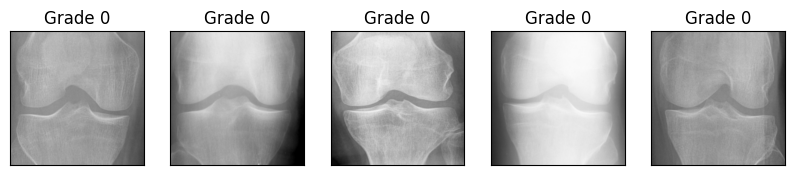

Train data - Doubtful


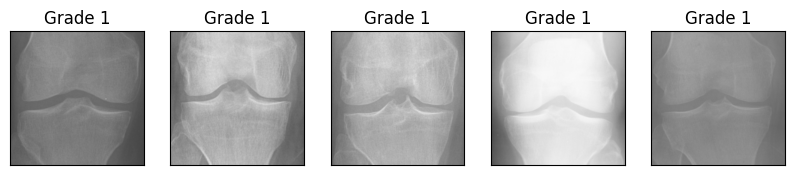

Train data - Minimal


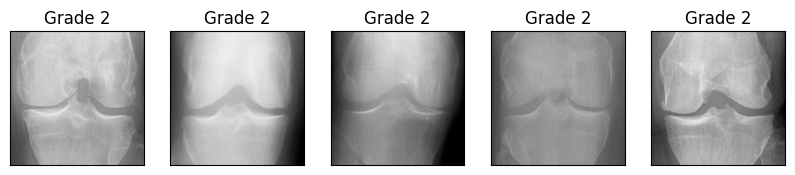

Train data - Moderate


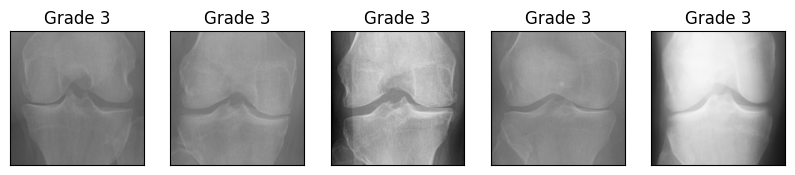

Train data - Severe


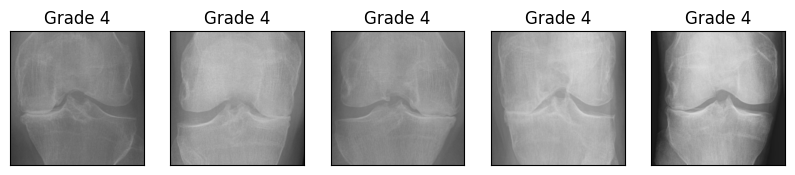

In [ ]:
plot_classes(train_data, train_path, class_names, 'Train data')

Test data

Test data - Healthy


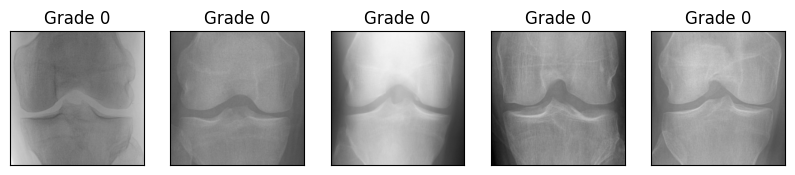

Test data - Doubtful


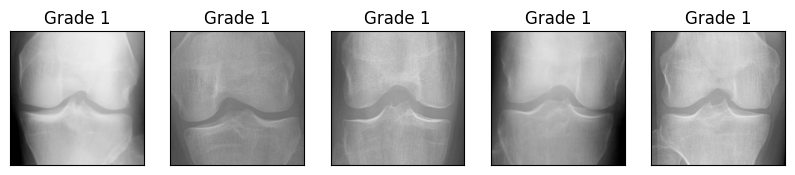

Test data - Minimal


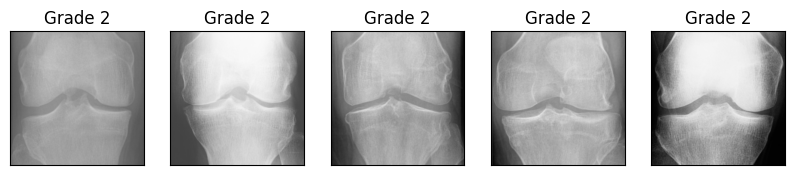

Test data - Moderate


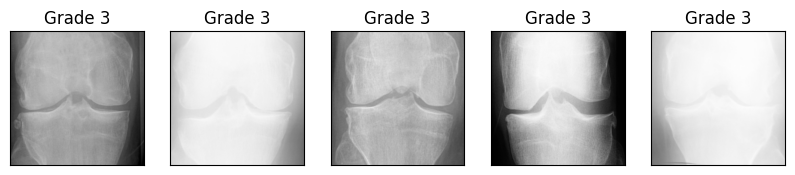

Test data - Severe


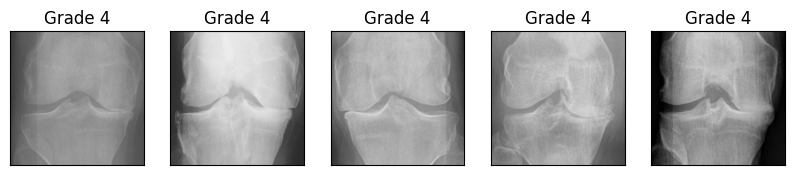

In [ ]:
plot_classes(tests_data, test_path, class_names, 'Test data')

Valid data

Valid data - Healthy


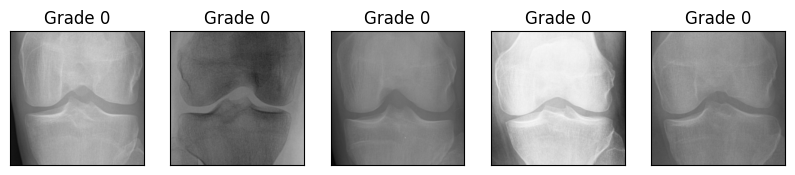

Valid data - Doubtful


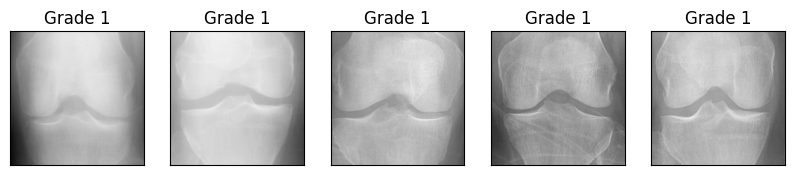

Valid data - Minimal


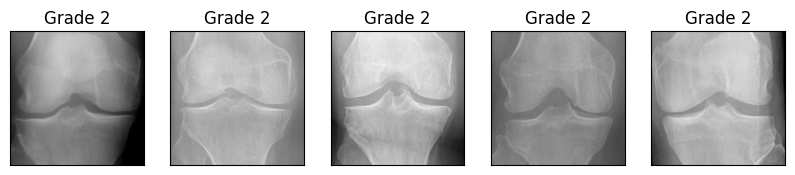

Valid data - Moderate


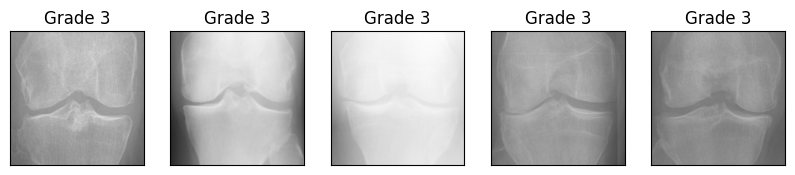

Valid data - Severe


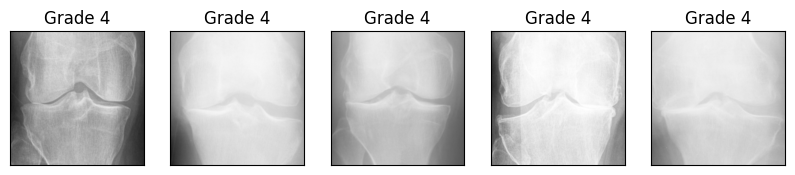

In [ ]:
plot_classes(valid_data, valid_path, class_names, 'Valid data')

### **Hyperparameters**

In [ ]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1


    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0:
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to')
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')
        self.start_time= time.time() # set the time at which training started

    def on_train_end(self, logs=None):   # runs at the end of training
        print('loading model with weights from epoch ', self.best_epoch)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        if v_loss< self.lowest_vloss:
            self.lowest_vloss=v_loss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1
            print (f'\n validation loss of {v_loss:7.4f} is below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights')
        else:
            print (f'\n validation loss of {v_loss:7.4f} is above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights')

        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()

                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                        print(f'current LR is  {lr:7.5f}  hit enter to keep  this LR or enter a new LR')
                        ans=input(' ')
                        if ans =='':
                            print (f'keeping current LR of {lr:7.5f}')
                        else:
                            new_lr=float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                            print(' changing LR to ', ans)

In [ ]:
print (train_df['labels'].value_counts())

Moderate    500
Severe      500
Healthy     500
Name: labels, dtype: int64


In [ ]:
max_samples=500
min_samples=500
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  500


In [ ]:
batch_size= 32

trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20 )
t_and_v_gen=ImageDataGenerator()

msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)

msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

Found 1500 validated image filenames belonging to 3 classes.
Found 461 validated image filenames belonging to 3 classes.
Found 913 validated image filenames belonging to 3 classes.


In [ ]:
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

test batch size:  11   test steps:  83  number of classes :  3


In [ ]:
def get_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

In [ ]:
def compute_confusion_matrix(ytrue, ypred, class_names, model_name):
    cm = confusion_matrix(
        y_true=ytrue.labels,
        y_pred=np.argmax(ypred, axis=1),
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)


In [ ]:
def get_evaluate(data, name, model):
    score_model = model.evaluate(data, verbose=1)
    print(f"{name} loss: {score_model[0]:.2f}")
    print(f"{name} accuracy: {score_model[1]:.2f}")

In [ ]:
def get_predict(data, model):
    predict_model = model.predict(data)
    return predict_model

In [ ]:
def get_metrics(y_test, y_pred, model_name):
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    print(f"Accuracy Score - {model_name}: {acc:.2f}")
    print(f"Balanced Accuracy Score - {model_name}: {bal_acc:.2f}")
    print("\n")

    print(classification_report(y_test, y_pred))

In [ ]:
#classes = np.unique(y_train)

# Callbacks
#early = tf.keras.callbacks.EarlyStopping(
            #monitor='val_loss', min_delta=0.01, patience=8,
            #restore_best_weights=True
        #)
#plateau = tf.keras.callbacks.ReduceLROnPlateau(
                #monitor='loss', factor=0.1, min_delta=0.01,
               # min_lr=1e-10, patience=4, mode='auto'
           # )

Inception - Resnet

In [ ]:
from keras import backend as K
K.clear_session()
tf.compat.v1.reset_default_graph()

In [ ]:
img_shape = (224, 224, 3)
model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    input_shape=(img_shape),
    include_top=False,
    weights="imagenet",
)

for layer in model.layers:
    layer.trainable = True

inc_res= tf.keras.models.Sequential(
    [
        model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(3, activation="softmax"),
    ]
)                                                                                     binary (2), categorical(>2)

inc_res.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy","AUC"])
inc_res.summary()

219055592/219055592 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 5, 5, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 3)                 4611      
                                                                 
Total params: 54341347 (207.30 MB)
Trainable params: 54280803 (207.06 MB)
Non-trainable params: 60544 (236.50 KB)
_______

In [ ]:
epochs=40
ask_epoch=10
ask=LR_ASK(inc_res, epochs,  ask_epoch)
callbacks=[ask]

In [ ]:
history=inc_res.fit(x=train_gen,
                      epochs=epochs,
                      verbose=1,
                      callbacks=callbacks,
                      validation_data=valid_gen,
                      validation_steps=None,
                      shuffle=False,
                      initial_epoch=0)

Training will proceed until epoch 10  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/40
47/47 [==============================] - ETA: 0s - loss: 0.5820 - accuracy: 0.7793 - auc: 0.9210
 validation loss of 132.8363 is below lowest loss, saving weights from epoch 1   as best weights
47/47 [==============================] - 139s 873ms/step - loss: 0.5820 - accuracy: 0.7793 - auc: 0.9210 - val_loss: 132.8363 - val_accuracy: 0.0976 - val_auc: 0.3090
Epoch 2/40
47/47 [==============================] - ETA: 0s - loss: 0.3052 - accuracy: 0.8920 - auc: 0.9727
 validation loss of  3.6110 is below lowest loss, saving weights from epoch 2   as best weights
47/47 [==============================] - 32s 682ms/step - loss: 0.3052 - accuracy: 0.8920 - auc: 0.9727 - val_loss: 3.6110 - val_accuracy: 0.6334 - val_auc: 0.7833
Epoch 3/40
47/47 [==============================] - ETA: 0s - loss: 0.2282 - accuracy: 0.9207 - au

In [ ]:
# Evaluate the model
get_evaluate(valid_gen, 'INC RES', inc_res)



# Get predictions for the validation set
y_pred = get_predict(valid_gen, inc_res)


15/15 [==============================] - 3s 163ms/step - loss: 0.1981 - accuracy: 0.9371 - auc: 0.9866
INC RES loss: 0.20
INC RES accuracy: 0.94
15/15 [==============================] - 5s 163ms/step


In [ ]:
y_train = train_gen.labels
y_val = valid_gen.labels

Accuracy Score - Inc Res: 0.94
Balanced Accuracy Score - Inc Res: 0.85


              precision    recall  f1-score   support

           0       0.95      0.98      0.97       328
           1       0.88      0.86      0.87       106
           2       0.95      0.70      0.81        27

    accuracy                           0.94       461
   macro avg       0.93      0.85      0.88       461
weighted avg       0.94      0.94      0.94       461



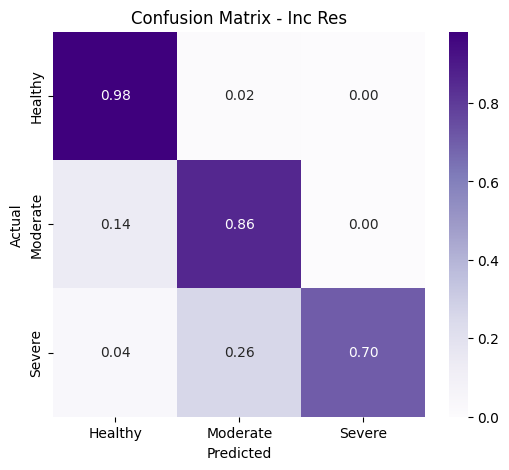

In [ ]:
# Compute and display metrics
get_metrics(y_val, np.argmax(y_pred, axis=1), 'Inc Res')

# Confusion matrix
compute_confusion_matrix(valid_gen, y_pred, class_names, 'Inc Res')

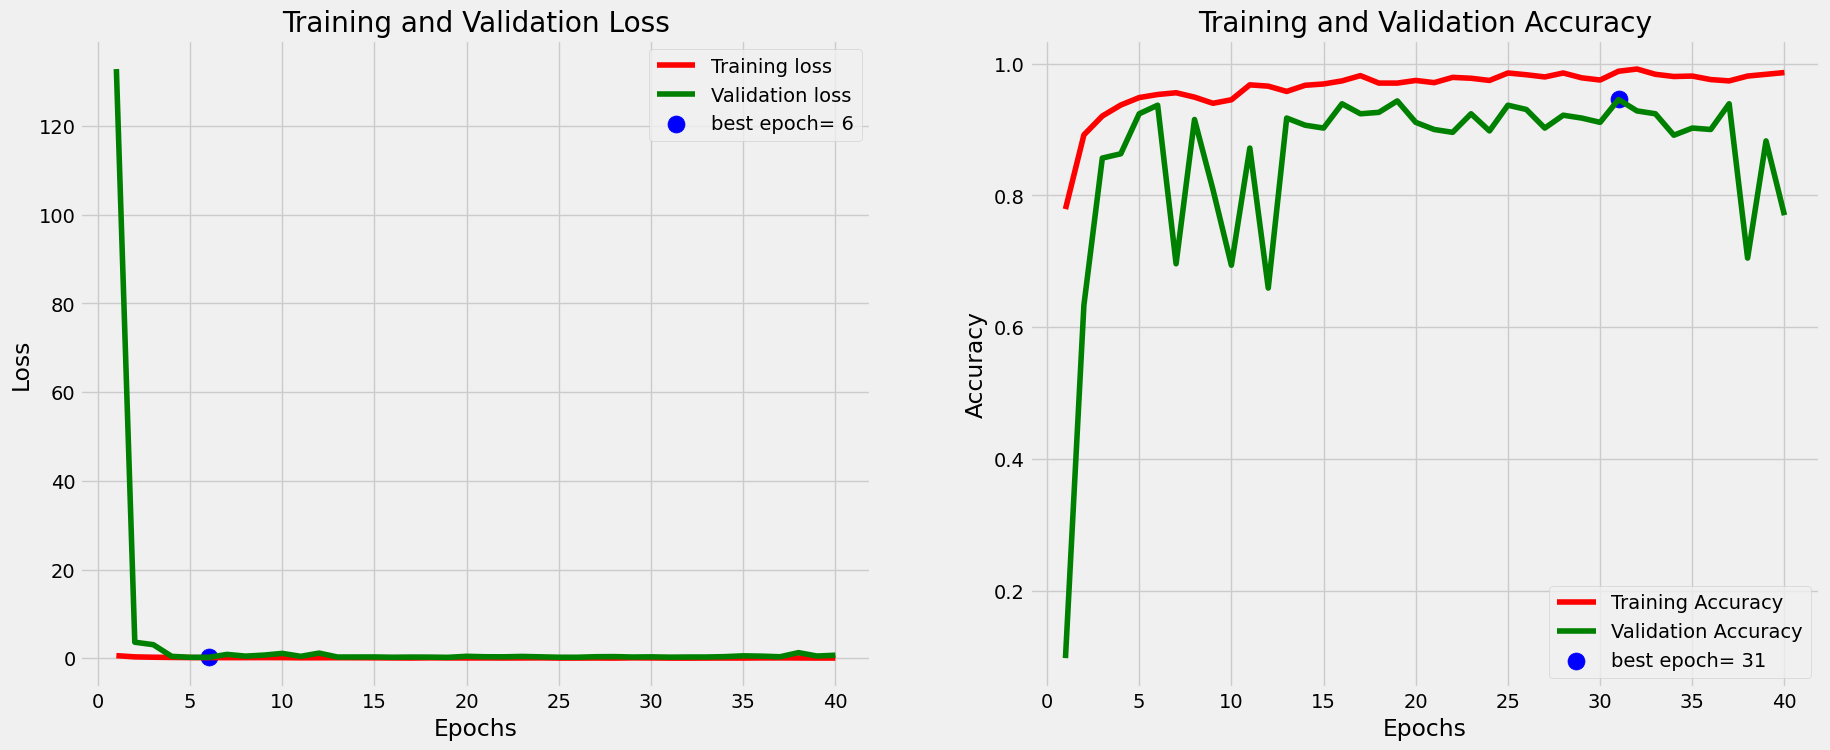

In [ ]:
# Plot loss and accuracy curves
get_plot(history, 0)

In [ ]:
inc_res.save("incres.h5")